<a href="https://colab.research.google.com/github/Schwarzam/tradutor-libras/blob/main/NN_leitor_numeros_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') ## MONTEI NO MEU DRIVE PARA USAR COMO HD

%cd drive/My Drive/TrainSets/TradutorLibras
!rm -rf tradutor-libras

!git clone https://github.com/schwarzam/tradutor-libras.git ## GIT CLONE DIRETO NO MEU DRIVE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TrainSets/TradutorLibras
Cloning into 'tradutor-libras'...
remote: Enumerating objects: 15936, done.
remote: Total 15936 (delta 0), reused 0 (delta 0), pack-reused 15936
Receiving objects: 100% (15936/15936), 335.56 MiB | 18.48 MiB/s, done.
Resolving deltas: 100% (4287/4287), done.
Checking out files: 100% (15737/15737), done.


In [ ]:
%cd tradutor-libras

/content/drive/My Drive/TrainSets/TradutorLibras/tradutor-libras


In [ ]:
pip install tensorflow==2.2.0

In [ ]:
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import SGD, RMSprop

from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.models import load_model
import random 

import os
from os import listdir
from os.path import isfile, join
from PIL import Image

import cv2
from skimage.io import imread

import matplotlib.pyplot as plt

In [ ]:
img_rows = 200 ## Comprimento imagem
img_cols = 200 ## Largura 
channels = 3 ## 3 porque eh colorida (3 bandas)_

def ler_imagens(file_paths, img_rows = 200, img_cols = 200, channels = 3):
  images = []
  for file_path in file_paths:
    im = imread(file_path)
    im = cv2.applyColorMap(im, cv2.COLORMAP_JET)
    images.append(im)

  images = np.asarray(images, dtype=np.float32)
  images = images / 255.0 #np.max(images) # normalizar
  images = images.reshape(images.shape[0], img_rows, img_cols, channels) # reshape para input no keras
  return images
  
def get_metadata(dataSet):
  label = []
  file_paths = []

  #Pegar pastas dentro de ./camera
  for folder in os.listdir(f'./numeros/{dataSet}'):
      if os.path.isdir(f'./numeros/{dataSet}/' + folder):
          ## Pegar todos arquivos da pasta
          for root, dirs, files in os.walk(os.path.abspath(f"./numeros/{dataSet}/" + folder)):
              for file in files:
                  file_paths.append(os.path.join(root, file))
                  label.append(str(folder))
  
  return label, file_paths

In [ ]:
ytrain, paths = get_metadata('train')
xtrain = ler_imagens(paths)

ytest, paths = get_metadata('test')
xtest = ler_imagens(paths)

yvalidation, paths = get_metadata('validation')
xvalidation = ler_imagens(paths)

ytrain = np.asarray(ytrain, dtype='int')
ytest = np.asarray(ytest, dtype='int')
yvalidation = np.asarray(yvalidation, dtype='int')

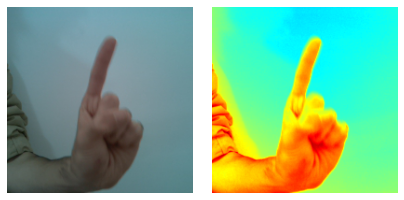

In [ ]:
from PIL import Image

im = Image.open('./numeros/train/1/imagem150.jpg')
im = np.array(im)

heatmap = cv2.applyColorMap(im, cv2.COLORMAP_JET)

plt.figure(1 , figsize = (7 , 5))

plt.subplot(1, 2, 1).axis('off')
plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
plt.imshow(im)

plt.subplot(1, 2, 2).axis('off')
plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
plt.imshow(heatmap)

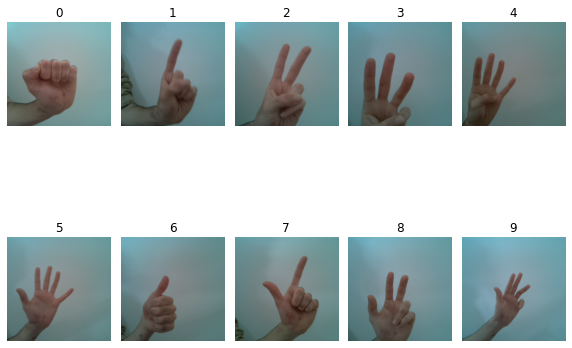

In [ ]:
plt.figure(1 , figsize = (10 , 7))

for i in range(10):
  plt.subplot(2, 5, i + 1).axis('off')
  plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
  plt.title(i)
  im = Image.open(f'./numeros/train/{i}/imagem150.jpg')
  plt.imshow(im)

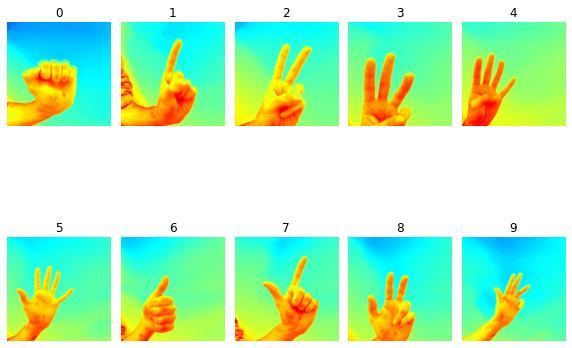

In [ ]:
plt.figure(1 , figsize = (10 , 7))

for i in range(10):
  plt.subplot(2, 5, i + 1).axis('off')
  plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
  plt.title(i)
  im = Image.open(f'./numeros/train/{i}/imagem150.jpg')
  im = np.array(im)
  im = cv2.applyColorMap(im, cv2.COLORMAP_JET)
  plt.imshow(im)

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

In [ ]:
model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.GlobalAveragePooling2D(name='avg_pool'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
from keras import optimizers
lr = 1e-5
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [ ]:
history = model.fit(xtrain, ytrain, 
          epochs=15, 
          batch_size = 16,
          steps_per_epoch=len(xtrain)/16,
          validation_data=(xvalidation, yvalidation),
          validation_steps = len(xvalidation)/16,
          verbose=1)

Epoch 1/15
250/250 [==============================] - 16s 65ms/step - loss: 0.7201 - accuracy: 0.8260 - val_loss: 0.4130 - val_accuracy: 0.9369
Epoch 2/15
250/250 [==============================] - 15s 60ms/step - loss: 0.0961 - accuracy: 0.9830 - val_loss: 0.1155 - val_accuracy: 0.9640
Epoch 3/15
250/250 [==============================] - 15s 60ms/step - loss: 0.0482 - accuracy: 0.9908 - val_loss: 0.0980 - val_accuracy: 0.9640
Epoch 4/15
250/250 [==============================] - 15s 60ms/step - loss: 0.0331 - accuracy: 0.9915 - val_loss: 0.0817 - val_accuracy: 0.9640
Epoch 5/15
250/250 [==============================] - 15s 60ms/step - loss: 0.0254 - accuracy: 0.9937 - val_loss: 0.0559 - val_accuracy: 0.9730
Epoch 6/15
250/250 [==============================] - 15s 60ms/step - loss: 0.0177 - accuracy: 0.9942 - val_loss: 0.0256 - val_accuracy: 0.9910
Epoch 7/15
250/250 [==============================] - 15s 60ms/step - loss: 0.0133 - accuracy: 0.9962 - val_loss: 0.0315 - val_accuracy:

In [ ]:
model.evaluate(x=xtest, y=ytest)

4/4 [==============================] - 0s 17ms/step - loss: 0.2519 - accuracy: 0.9900


[0.25187480449676514, 0.9900000095367432]

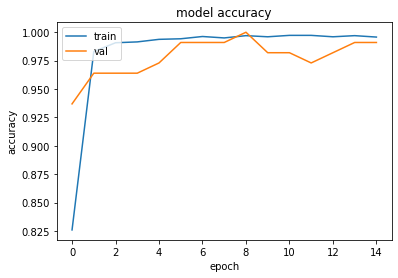

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

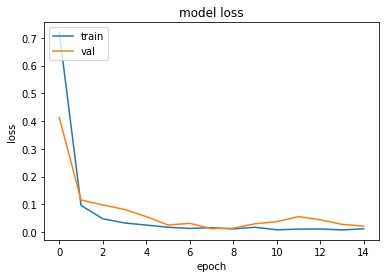

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(xtest)

arr = []
for predict in pred:
  arr.append(np.argmax(predict, axis=-1))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(arr, ytest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       0.90      1.00      0.95         9
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
model.save('/content/drive/My Drive/TrainSets/rede_neural_tf_numeros_InceptionV3_99%.h5')

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print("Loss = ",loss,"\nAccuracy = ",accuracy) 
model.save('/content/drive/My Drive/TrainSets/TradutorLibras/tradutor-libras/rede_neural_tf_v2.2.0.h5')    